# Explore here

It's recommended to use this notebook for exploration purposes.

HTML content retrieved successfully.
Number of tables found: 4
Found a table with 'Date' and 'Value' columns.
Found a table with 'Date' and 'Value' columns.

Processing table 1 with 'Date' and 'Value' columns

Processing table 2 with 'Date' and 'Value' columns


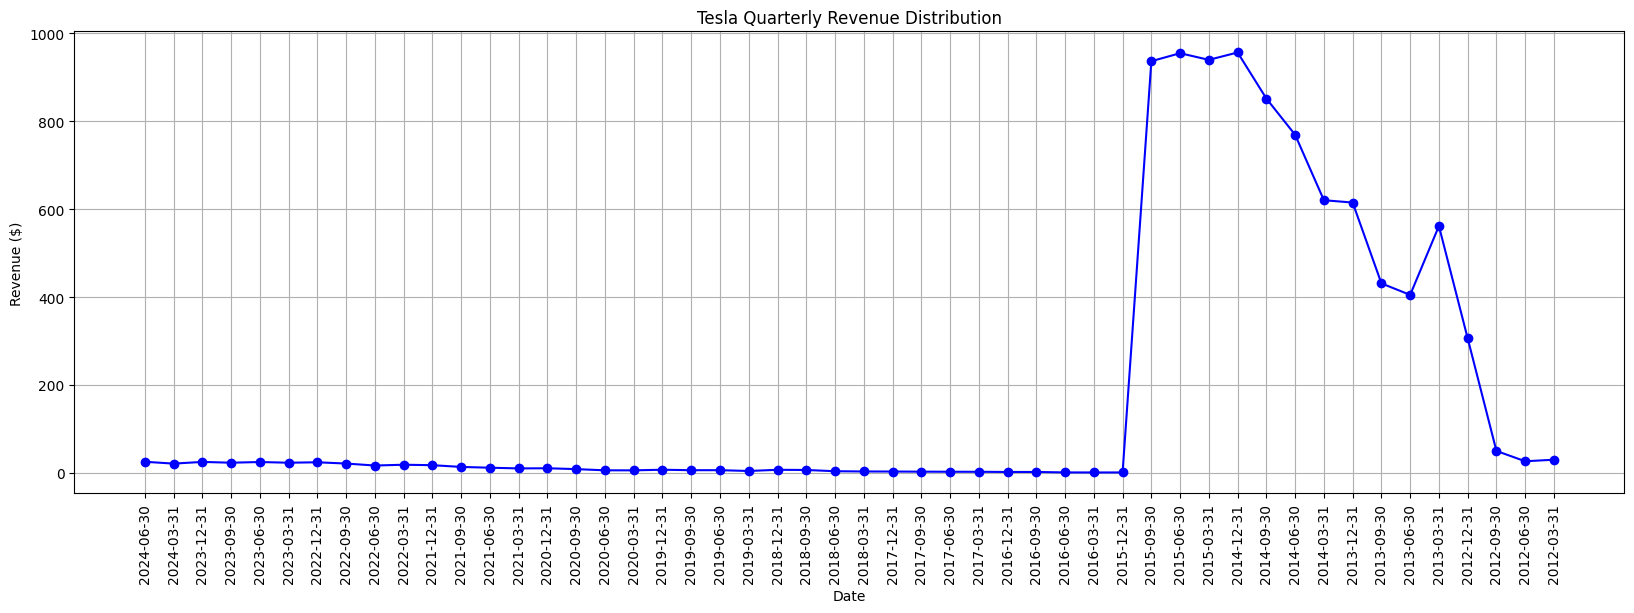

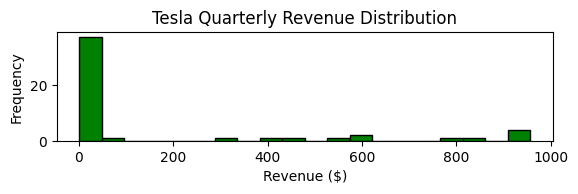

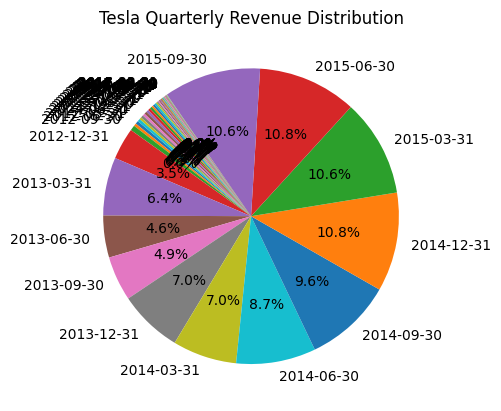

In [1]:
import os
from bs4 import BeautifulSoup
import requests
import sqlite3
import matplotlib.pyplot as plt
import pandas as pd

# URL to scrape
url = 'https://ycharts.com/companies/TSLA/revenues'

# Headers to mimic a request from a web browser
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

# Retrieve HTML content
response = requests.get(url, headers=headers)

if response.status_code == 200:    
    html_content = response.text  
    print("HTML content retrieved successfully.")
else:
    print(f"Failed to retrieve the webpage. Status code: {response.status_code}")

# Parse HTML content
soup = BeautifulSoup(response.content, 'html.parser')

# Find all tables
tables = soup.find_all('table')
print(f"Number of tables found: {len(tables)}")

# Filter only tables with 'Date' and 'Value' columns
relevant_tables = []
for table in tables:
    headers = [th.text.strip() for th in table.find_all('th')]
    if 'Date' in headers and 'Value' in headers:
        print("Found a table with 'Date' and 'Value' columns.")
        relevant_tables.append(table)

# Process each relevant table with 'Date' and 'Value' headers
data = []
for i, table in enumerate(relevant_tables):
    print(f"\nProcessing table {i+1} with 'Date' and 'Value' columns")
    rows = table.find_all('tr')
    headers = [th.text.strip() for th in rows[0].find_all('th')]
    
    for row in rows[1:]:  # Skip the header row
        cols = [td.text.strip() for td in row.find_all('td')]
        data.append(cols)

# Create DataFrame
df = pd.DataFrame(data, columns=headers)

# Cleanup DataFrame
df['Value'] = df['Value'].replace('[\$,]', '', regex=True)  # Remove $, and ,
df['Value'] = df['Value'].replace({'B': '', 'M': ''}, regex=True)  # Remove B and M
df['Value'] = pd.to_numeric(df['Value'], errors='coerce')  # Convert to numeric
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df_cleaned = df.dropna()
df_cleaned['Date'] = df_cleaned['Date'].dt.strftime('%Y-%m-%d')

# Store cleaned data in SQLite
conn = sqlite3.connect('tesla.db')
df_cleaned.to_sql('revenues', conn, if_exists='replace', index=False)
conn.close()

# Load data from SQLite
conn = sqlite3.connect('tesla.db')
df = pd.read_sql_query("SELECT * FROM revenues", conn)
conn.close()

# Plot the data
plt.figure(figsize=(20, 6))
plt.plot(df['Date'], df['Value'], marker='o', linestyle='-', color='b')

# Add titles and labels
plt.title('Tesla Quarterly Revenue Distribution')
plt.xlabel('Date')
plt.ylabel('Revenue ($)')
plt.grid(True)
plt.xticks(rotation=90)
plt.show()

# Histogram
plt.subplot(3, 1, 2)
plt.hist(df['Value'], bins=20, color='g', edgecolor='black')
plt.title('Tesla Quarterly Revenue Distribution')
plt.xlabel('Revenue ($)')
plt.ylabel('Frequency')
plt.show()

# Pie Chart
plt.subplot(1, 1, 1)
df['Date'] = df['Date']
revenue_by_year = df.groupby('Date')['Value'].sum()
plt.pie(revenue_by_year, labels=revenue_by_year.index, autopct='%1.1f%%', startangle=140)
plt.title('Tesla Quarterly Revenue Distribution')
plt.show()